In [1]:
from __future__ import print_function

%matplotlib inline
import numpy as np 
import scipy.misc # to visualize only  
import pandas as pd
import matplotlib.pyplot as plt
import string
# !pip install tensorflow
import tensorflow as tf
print(tf.test.gpu_device_name())
# !pip install opencv-python
import cv2
import pandas as pd

# !pip install keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, Input, concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from math import exp
import warnings
import math
import random
import itertools
# !pip install sklearn
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

from keras.models import model_from_json

# !pip install xgboost
import xgboost
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV

#cnn with xgboost
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

import sys
import numpy as np
import cv2
import sklearn.metrics as sklm

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model, load_model
from keras.datasets import mnist

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

train_images = pd.read_pickle('./train_images.pkl')
train_labels = pd.read_csv('./train_labels.csv')
test_images = pd.read_pickle('./test_images.pkl')

Using TensorFlow backend.


# Preprocessing

In [2]:
# Preprocessing
x = train_images
y = train_labels['Category'].values
x = x.reshape(-1, 64, 64)
y = y.reshape(-1, 1) 
x = np.int64(x)
y = np.int64(y)

test = test_images
test = test.reshape(-1, 64, 64)
test = np.int64(x) 
    
def preprocess(image):
    connectivity = 4
    img = image.astype(np.uint8)
    _,thresh = cv2.threshold(img,254,255,cv2.THRESH_BINARY)
    
    img_blurred = cv2.blur(img,(3,3))

    _,thresh_blurred = cv2.threshold(img_blurred,205,255,cv2.THRESH_BINARY)    

    output = cv2.connectedComponentsWithStats(thresh_blurred, connectivity, cv2.CV_32S)
    n_components = output[0] - 1
    stats = output[2][1:]
    
    # Too many high intensity parts, go without blur
    if n_components >= 4:
        output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
        n_components = output[0] - 1
        stats = output[2][1:]
    
     
    largest_component = np.array([])
    largest_area = 0
    largest_length = 0
    largest_height = 0
    for i in range(n_components):
        
        left = stats[i][0]
        top = stats[i][1]
        length = stats[i][2]
        height = stats[i][3]
        if max(length,height) >=32:
            continue
        area = max(length,height) ** 2 # for square bounding box
        
        if(area > largest_area):
            largest_area = area
            largest_length = length
            largest_height = height
            largest_component = thresh[top:height+top, left:left+length]

            
    result = np.zeros([64,64],dtype=np.uint8)
    result[0:largest_height,0:largest_length] = result[0:largest_height,0:largest_length] + largest_component    
    result = result[:32,:32]
    return result


x1 = np.zeros([x.shape[0],32,32],dtype=np.uint8)
test1 = np.zeros([x.shape[0],32,32],dtype=np.uint8)
for i in range(x.shape[0]):
    x1[i] = preprocess(x[i])

In [3]:
num_classes = 10
img_dim = 32

x_train, x_val, y_train, y_val = train_test_split(x1, y, test_size=0.2)

x_train = x_train.reshape(x_train.shape[0], img_dim, img_dim, 1)
x_val = x_val.reshape(x_val.shape[0], img_dim, img_dim, 1)
input_shape = (img_dim, img_dim, 1)


x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255


y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)

# Model1

In [5]:
num_classes = 10
batch_size = 32
epochs = 25

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same',input_shape=input_shape))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization(axis=-1))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization(axis=-1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()


lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=4,min_lr=0.5e-9)
callbacks = [lr_reducer, lr_scheduler]


history = model.fit(x_train, y_train, 
                              batch_size=batch_size, 
                              epochs = epochs, callbacks=callbacks, validation_data = (x_val,y_val))
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [6]:
model.save('arch3_preprocessed.h5')  # creates a HDF5 file 'my_model.h5'

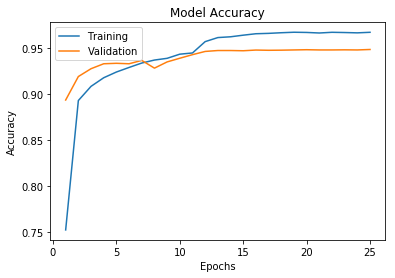

In [7]:
plt.plot(range(1, epochs + 1), history.history['acc'])
plt.plot(range(1, epochs +1), history.history['val_acc'])
plt.legend(['Training', 'Validation'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

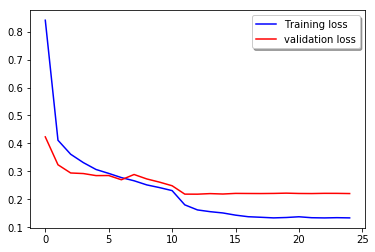

In [8]:
plt.figure()
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best', shadow=True)

# Plot confusion matrix and error cases
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

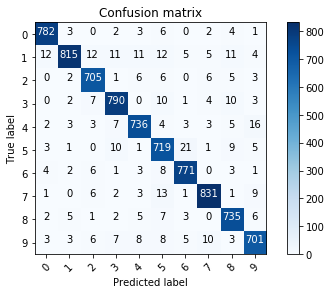

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

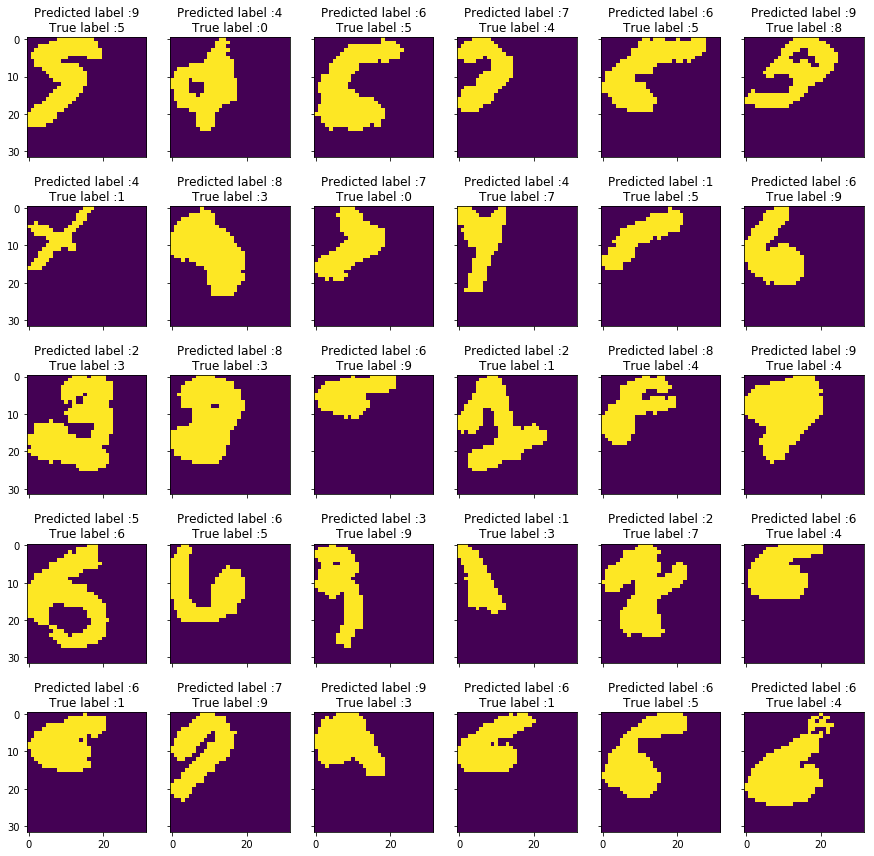

In [11]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 5
    ncols = 6
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,15))
    for row in range(nrows):
        for col in range(ncols):
            
            error = errors_index[n]
#             print(error)
            ax[row,col].imshow((img_errors[error]).reshape((32,32)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
# most_important_errors = sorted_dela_errors[-6:]
most_important_errors = sorted_dela_errors[-30:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Make Predictions

In [16]:
x_test = test_images.reshape(-1, 64, 64) # reshape 
x_test = np.uint8(x_test)
processed = []
    
for i in range(len(x_test)):
    ret,thresh = cv2.threshold(x_test[i],254,255,cv2.THRESH_BINARY)
    processed.append(thresh)
processed = np.array(processed)
data = processed.reshape(processed.shape[0], 64, 64, 1)


data = data.astype('float32')
data /= 255
predict = model.predict_classes(data)
my_submission = pd.DataFrame({'Id': np.arange(len(predict)), 'Category': predict})
my_submission.to_csv('submission_arch3.csv', index=False)

In [17]:
my_submission.head(15)

,Id,Category
0,0,7
1,1,1
2,2,6
3,3,1
4,4,8
5,5,3
6,6,3
7,7,5
8,8,9
9,9,4
